## Regression Testing

Neural networks that dedicate to predicting a numerical output than a class. 

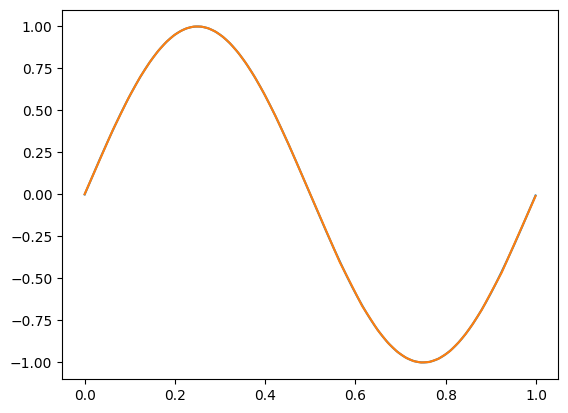

In [6]:
import nnfs 
import numpy as np 
from matplotlib import pyplot as plt
from nnfs.datasets import sine_data
from Optimizers import Optimizer_Adam
from nnfs.datasets import spiral_data 

nnfs.init()

class neuroNetworkLayer:
    def __init__(self, itemsInArray, Dimensions, weightsRegulizationL1 = 0, biasRegulizationL1 = 0, weightsRegulizationL2 = 0, biasRegulizationL2 = 0):
        self.weights = 0.01 * np.random.randn(itemsInArray, Dimensions)
        #Weights must be as close as possible to zero 
        #! self.weights = np.zeros((itemsInArray, Dimensions))
        self.bias = np.zeros((1,Dimensions))
        #! bias MUST START WITH ZEROS
        self.weightsRegulizationL1 = weightsRegulizationL1
        self.biasRegulizationL1 = biasRegulizationL1
        self.weightsRegulizationL2 = weightsRegulizationL2
        self.biasRegulizationL2 = biasRegulizationL2

        #! Only apply regulization at the second Layer
    
    def forward(self,inputs):
        self.input = inputs 
        self.outputs = np.dot(self.input, self.weights) + self.bias #softMaxFunction(pushForward(np.dot(self.input,self.weights)) + self.bias)
       # print(self.outputs)

    def backwards(self, dvalues):
        self.dweights = np.dot(self.input.T, dvalues)

        self.dbias = np.sum(dvalues, axis = 0, keepdims = True)
        

        #Backward pass of the regulization
        if self.weightsRegulizationL1 > 0:
            dL1weights = np.ones_like(self.weights)
            dL1weights[self.weights < 0] = -1
            
            self.dweights += self.weightsRegulizationL1 * dL1weights
        
        if self.biasRegulizationL1 > 0:
            dL1weights = np.ones_like(self.bias)
            dL1weights[self.bias < 0] = -1

            self.dbias += self.biasRegulizationL1 * dL1weights
        
        if self.weightsRegulizationL2 > 0:
            self.dweights += self.weightsRegulizationL2 * 2 * self.weights
        
        if self.biasRegulizationL2 > 0:
            self.dbias += self.biasRegulizationL2 * 2 * self.bias

        self.dinputs = np.dot(dvalues, self.weights.T)

class FunctionLoss:
    def calculate(self, outputs, targetedClass):
        sampleLoss = self.forward(outputs, targetedClass)
        return np.mean(sampleLoss)

    def regulizationForward(self, layer):
        lossRegulizationloss = 0 

        #L1 Regulization
        lossRegulizationloss += layer.weightsRegulizationL1 * np.sum(np.abs(layer.weights))
        lossRegulizationloss += layer.biasRegulizationL1 * np.sum(np.abs(layer.bias))
        
        #L2 Regulization
        lossRegulizationloss += layer.weightsRegulizationL2 * np.sum(np.abs(layer.weights**2))
        lossRegulizationloss += layer.biasRegulizationL2 * np.sum(np.abs(layer.bias**2))

        return lossRegulizationloss

class activateRELU:
    def forward(self, inputs):
        self.inputs = inputs
        self.outputs = np.maximum(0,inputs)
    def backwards(self, gradients):
        self.dinputs = gradients.copy()
        self.dinputs[self.inputs <= 0] = 0

        #apply the activateRelU function to the derivatives - because values that
        #went 0 should not have an impact after this point 

class LinearActivation:
    def forward(self, inputs):
        self.inputs = inputs 
        self.outputs = inputs 

    def backwards(self, dvalues):
        self.dinputs = dvalues.copy()

class MeanSquaredError(FunctionLoss):
    def forward(self, outputs, realY):
        sampleLoss = np.mean((realY - outputs)**2, axis = -1)
        return sampleLoss
    
    def backwards(self, outputs, realY):
        dimensions = outputs.shape
        self.dinputs = -2*(realY - outputs)/dimensions[0]/dimensions[1]

class MeanAbsoluteError(FunctionLoss):
    def forward(self, outputs, realY):
        sampleLoss = np.mean(np.abs((realY - outputs)), axis = -1)
        return sampleLoss

    def backwards(self, dvalues, realY):
        dimensions = dvalues.shape
        self.dinputs = np.sign(realY - dvalues)/dimensions[1]/dimensions[0]
        #! The dinputs is too large - Don't use this


X, y = sine_data()
Xtest, ytest = sine_data()
Layer1 = neuroNetworkLayer(1,64)
Layer2 = neuroNetworkLayer(64,64)
Layer3 = neuroNetworkLayer(64,1)
#? Creating additional layers allows the graph to bend more
Activation = activateRELU()
Activation2 = activateRELU()
linear = LinearActivation()
loss = MeanSquaredError()
#loss = MeanAbsoluteError()
Optimizer = Optimizer_Adam(rate = 0.005, decay = 1e-3)


accuracyRange = np.std(y)/250 #the bigger this number beside 250 means the stricter the machien have to get 
#accuracy = np.mean(np.abs(y - predictedValues) < accuracyRange)

for epoch in range(10000):
    Layer1.forward(X)
    Activation.forward(Layer1.outputs)
    Layer2.forward(Activation.outputs)
    Activation2.forward(Layer2.outputs)
    Layer3.forward(Activation2.outputs)
    linear.forward(Layer3.outputs)

    NormalLoss = loss.calculate(linear.outputs, y)
    RegulizationLoss = loss.regulizationForward(Layer1) + loss.regulizationForward(Layer2) + loss.regulizationForward(Layer3)
    ActualLoss = NormalLoss + RegulizationLoss

    accuracy = np.mean(np.abs(y - linear.outputs) < accuracyRange)
    '''
    if epoch % 100 == 0:
        print('e1', epoch)
        print('p', accuracy)
        print('l', ActualLoss)
        print('nl', NormalLoss)
        print('rl', RegulizationLoss)
    '''

    loss.backwards(linear.outputs, y)
    linear.backwards(loss.dinputs)
    Layer3.backwards(linear.dinputs)
    Activation2.backwards(Layer3.dinputs)
    Layer2.backwards(Activation2.dinputs)
    Activation.backwards(Layer2.dinputs)
    Layer1.backwards(Activation.dinputs)

    Optimizer.adjustRate()
    Optimizer.updateWeightsBias(Layer1)
    Optimizer.updateWeightsBias(Layer2)
    Optimizer.updateWeightsBias(Layer3)
    Optimizer.updateStep()

Layer1.forward(Xtest)
Activation.forward(Layer1.outputs)
Layer2.forward(Activation.outputs)
Activation2.forward(Layer2.outputs)
Layer3.forward(Activation2.outputs)
linear.forward(Layer3.outputs)

plt.plot( Xtest, ytest)
plt.plot(Xtest, linear.outputs)
plt.show()


This is to train the dataset

p 0.97
l 1.2439827586724436e-06
nl 1.2439827586724436e-06
rl 0.0


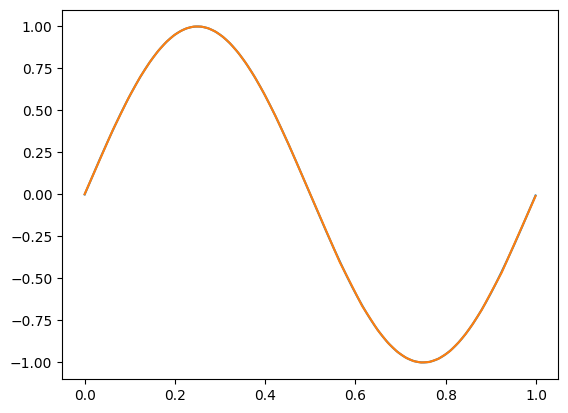

In [7]:
Layer1.forward(Xtest)
Activation.forward(Layer1.outputs)
Layer2.forward(Activation.outputs)
Activation2.forward(Layer2.outputs)
Layer3.forward(Activation2.outputs)
linear.forward(Layer3.outputs)

NormalLoss = loss.calculate(linear.outputs, ytest)
RegulizationLoss = loss.regulizationForward(Layer1) + loss.regulizationForward(Layer2) + loss.regulizationForward(Layer3)
ActualLoss = NormalLoss + RegulizationLoss
accuracy = np.mean(np.abs(ytest - linear.outputs) < accuracyRange)

print('p', accuracy)
print('l', ActualLoss)
print('nl', NormalLoss)
print('rl', RegulizationLoss)

plt.plot( Xtest, ytest)
plt.plot(Xtest, linear.outputs)
plt.show()

This is the testing of the network. 